In [3]:
"""Compare the results within the average_first_pulse_fit_force_sign 
table and the average_first_pulse_fit_any_sign table.  The difference
is whether or not the sign of the fit amplitude is forced to the measured 
value.  This requires data saved into .csv files created from 
analyze_first_pulse_average.ipynb.
"""
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook  
matplotlib.rcParams['figure.figsize'] = [8, 8]
# import mpld3
# mpld3.enable_notebook()


In [4]:
forced_df=pd.read_csv('average_fit_forced_sign_10_01_18.csv')  #data loaded from query above
any_df=pd.read_csv('average_fit_any_sign_10_01_18.csv')

In [6]:
#Merge the any sign versus forced sign data frames
merged_df = pd.merge(forced_df, any_df, on=['uid', 'pre_cell_id', 'post_cell_id', 
                                            'boolean_connection', 'distance', 
                                            'syn_excitation','measured_amp',
                                           'measured_baseline'], how='inner', suffixes={'_f', '_a'})
merged_df['uid']=merged_df['uid'].astype(str)

# note that the length of the merged data frame equaling the len of the smallest 
# individual dataframe shows that the values being merged on are the same in the
# two databases.
print(len(forced_df))
print(len(any_df))
print(len(merged_df))
connected_df=merged_df[merged_df['boolean_connection']==True]

10713
10725
10713


<IPython.core.display.Javascript object>


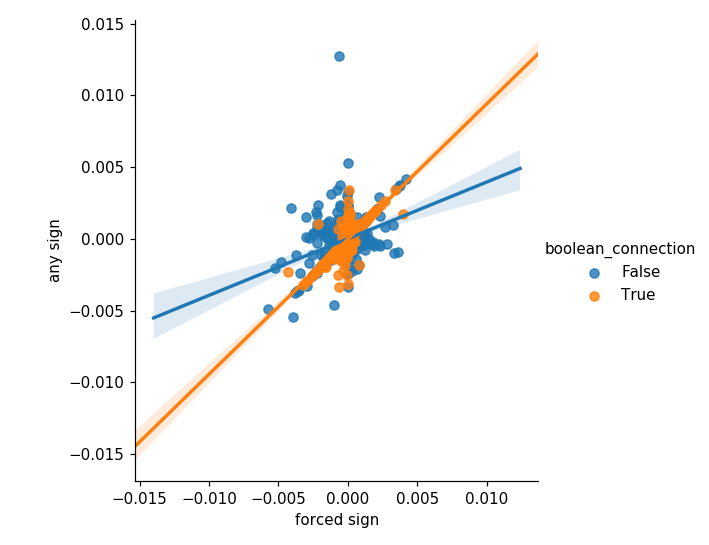

Text(57.642,0.5,'any sign')

In [7]:
#Check to see if relationships are linear
sns.lmplot(x="amp_f", y="amp_a", hue='boolean_connection', data=merged_df)
plt.xlabel('forced sign')
plt.ylabel('any sign')

In [ ]:
#Perhaps the ones that dont match well should be eliminated?
print(len(connected_df))
sns.lmplot(x="amp_f", y="amp_a", hue='syn_excitation', data=connected_df)
plt.xlabel('forced sign')
plt.ylabel('any sign')



In [ ]:
plt.figure()
sc=plt.scatter(x=connected_df["amp_f"], y=connected_df["amp_a"], c=connected_df['NRMSE_f'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')

In [ ]:
plt.figure()
sc=plt.scatter(x=connected_df["amp_f"], y=connected_df["amp_a"], c=connected_df['NRMSE_a'],  s=35, cmap='jet')
plt.colorbar(sc)
plt.xlabel('forced sign')
plt.ylabel('any sign')


In [ ]:
def isclose():
    

In [9]:
connected_and_eq=connected_df.loc[math.isclose(connected_df['amp_f'], connected_df['amp_a'])]
connected_and_uneq=connected_df.loc[~math.isclose(connected_df['amp_f'], connected_df['amp_a'])]

AttributeError: 'module' object has no attribute 'isclose'

In [12]:
import math
math.isclose(connected_df['amp_f'], connected_df['amp_a'])

AttributeError: 'module' object has no attribute 'isclose'

In [15]:
math.isclose(5.6, 5.2)

AttributeError: 'module' object has no attribute 'isclose'

In [ ]:
print(len(connected_and_eq))
print(len(connected_and_uneq))

In [ ]:
df=connected_and_eq[['uid','pre_cell_id', 'post_cell_id', 'amp_x', 'amp_y']]

In [ ]:
df.sort_values('uid')

In [ ]:
df=merged_df[merged_df['boolean_connection']==False]
plt.plot(df['amp_x'], df['amp_y'], '.')